<a href="https://colab.research.google.com/github/karljackson1988/Land-Registry-Transactions/blob/main/Land_Registry_Transactions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Land Registry Transactions: Spatial & Temporal Market Analysis

##**Uncovering regional housing market dynamics through data science**

##**Project Overview**

This project explores patterns in UK property transactions over time and geography using public Land Registry data. The goal is to reveal how property markets behave across regions — identifying emerging growth areas, price volatility, and market segmentation.

By analysing millions of transaction records, the project helps illuminate how the housing market functions as a collection of distinct “micro-markets.”
These insights can support:

First-time buyers identifying affordable entry points.

Homeowners and developers timing moves or investments.

Policy analysts and lenders assessing market stability and local growth patterns.




---



##**Data Science Approach**
From a technical standpoint, this project integrates data engineering, exploratory data analysis (EDA), and machine learning to turn raw property transactions into interpretable market segments.

ETL pipeline: Built in Python with pandas, ingesting and cleaning >10M rows from the UK Land Registry Price Paid Dataset
.

Storage optimisation: Converted raw CSVs to Parquet for faster reloads and efficient iteration.

Feature engineering: Derived regional price trends, volatility, and transaction density metrics.

Unsupervised learning: Applied K-Means clustering to group postcode areas with similar pricing behaviour — forming data-driven market “tiers.”

Visualisation: Created clear, interpretable visual outputs using matplotlib and seaborn for trend and cluster interpretation.


---


#**Core Questions Explored**

•	How have average property prices changed over time?
We summarise nominal prices monthly/annually and look for structural shifts (e.g., post-2016, pandemic period, recent rate rises).

•	Which property types have appreciated the most?
Splitting the time series by Detached/Semi/ Terrace/Flat reveals different cycles and sensitivities.

•	Are there postcode regions with consistently high or low prices?
Aggregations at outward postcode (e.g., SW, L, B) and sector level show broad regional bands.

•	Can regional clusters be identified using machine learning?
K-Means segments areas with similar price levels and sales activity to surface “market tiers.”

Tools & Technologies
•	Python: ETL, analysis, visualization
•	Pandas: Data processing
•	Seaborn/Matplotlib: Visual exploration
•	Scikit-learn: K-Means clustering
•	Parquet: Optimized data storage format


import relevant libraries.

Define relevant date periods.

Declare location to gather data from.

Create an empty dataframe.

In [2]:
import pandas as pd

start = 2015
end = 2026

years = range(start, end)
base_url = "http://prod.publicdata.landregistry.gov.uk.s3-website-eu-west-1.amazonaws.com/pp-{}.txt"

# Empty list to collect each year's DataFrame
all_data = []

run loop to extract data for defined date periods.

In [3]:
for year in years:
    url = base_url.format(year)
    try:
        df = pd.read_csv(url, sep=',', header=None, dtype=str)
        df['Year'] = year
        all_data.append(df)
        print(f"Loaded data for {year}")
    except Exception as e:
        print(f"Failed to load data for {year}: {e}")



Loaded data for 2015
Loaded data for 2016
Loaded data for 2017
Loaded data for 2018
Loaded data for 2019
Loaded data for 2020
Loaded data for 2021
Loaded data for 2022
Loaded data for 2023
Loaded data for 2024
Loaded data for 2025


Append / Concatenate all yealry data files into a single dataframe.

In [4]:
# Combine all into one DataFrame
full_data = pd.concat(all_data, ignore_index=True)

In [5]:
#full_data

Specify the columnular naming convention.

In [6]:
columns = [
    "Transaction unique identifier", "Price", "Date of Transfer", "Postcode",
    "Property Type", "Old/New", "Duration", "PAON", "SAON",
    "Street", "Locality", "Town/City", "District", "County",
    "PPD Category Type", "Record Status"
]

Add the data year as a column data point.

In [7]:
full_data.columns = columns + ["Year"]

Check for missing values by column

In [8]:

missing_values = full_data.isnull().sum()
missing_percent = (missing_values / len(full_data)) * 100
missing_summary = pd.DataFrame({
    "Missing Values": missing_values,
    "Percent Missing": missing_percent
})
print("Missing Data Summary:\n", missing_summary.sort_values(by="Percent Missing", ascending=False))


Missing Data Summary:
                                Missing Values  Percent Missing
SAON                                  9166356        86.410135
Locality                              6602536        62.241312
Street                                 188537         1.777316
Postcode                                36136         0.340650
Transaction unique identifier               0         0.000000
Property Type                               0         0.000000
Old/New                                     0         0.000000
Date of Transfer                            0         0.000000
Price                                       0         0.000000
PAON                                        0         0.000000
Duration                                    0         0.000000
Town/City                                   0         0.000000
District                                    0         0.000000
County                                      0         0.000000
PPD Category Type               

SAON (Secondary Addressable Object Name): This field typically includes details like apartment numbers or suites. With over 86% missing, it is likely only applicable to a subset of urban addresses. Its removal was deemed appropriate to avoid skewing downstream analysis.



---



Locality: Although this field can provide additional context to the address, over 60% is missing and it often overlaps with more complete fields like Town/City, District, and Postcode. Therefore, it was excluded to streamline the dataset.

Street, PAON, Postcode: These fields had very low levels of missingness and were retained for their importance in geospatial or property-specific analyses.

In [9]:
# Drop high-missing-value columns
full_data = full_data.drop(columns=["SAON", "Locality"])

Extract the first [n] characters for the postcode area based on example:

Formatting
Overview
The postcodes are alphanumeric, and are (possibly uniquely) variable in length: ranging from six to eight characters (including a space). Each postcode is divided into two parts separated by a single space: the outward code and the inward code respectively. The outward code includes the postcode area and the postcode district, respectively. The inward code includes the postcode sector and the postcode unit respectively. Examples of postcodes are "SW1W 0NY", "PO16 7GZ", "GU16 7HF", and "L1 8JQ".

POSTCODE:        SW1W 0NY

Outward code:    SW

Inward code:     1W

Area	District:  0

Sector	Unit:    NY


In [10]:
full_data["Postcode_Area"] = full_data["Postcode"].str.extract(r'^(\S+)')

Ensure the "Price" is stored as an integer

In [11]:
full_data["Price"] = pd.to_numeric(full_data["Price"], errors="coerce")

In [12]:
# Keep only residential, valid, private sales
full_data = full_data[
    (full_data['PPD Category Type'] == 'A') &
    (full_data['Price'] < 10000000) &
    (full_data['Price'] > 1_000)
]


In [13]:
full_data.columns

Index(['Transaction unique identifier', 'Price', 'Date of Transfer',
       'Postcode', 'Property Type', 'Old/New', 'Duration', 'PAON', 'Street',
       'Town/City', 'District', 'County', 'PPD Category Type', 'Record Status',
       'Year', 'Postcode_Area'],
      dtype='object')

In [14]:
# Distinct counts
print("Distinct Record Status:", full_data["Record Status"].nunique())
print("Distinct Town/City:", full_data["Town/City"].nunique())
print("Distinct Districts:", full_data["District"].nunique())
print("Distinct Counties:", full_data["County"].nunique())

Distinct Record Status: 1
Distinct Town/City: 1152
Distinct Districts: 361
Distinct Counties: 117


In [15]:
#full_data.to_parquet("land_registry_data_2005_2025.parquet", index=False)

In [16]:
import random

# Drop NaNs first to avoid errors
valid_postcodes = full_data["Postcode"].dropna().unique()

# Randomly pick one postcode
random_postcode = random.choice(valid_postcodes)

# Filter the dataset for that postcode
postcode_area = full_data[full_data["Postcode"] == random_postcode]

print(f"Randomly selected postcode: {random_postcode}")



Randomly selected postcode: EX31 3PG


In [17]:
postcode_area

,Transaction unique identifier,Price,Date of Transfer,Postcode,Property Type,Old/New,Duration,PAON,Street,Town/City,District,County,PPD Category Type,Record Status,Year,Postcode_Area
1395923,{3E0330EF-8F29-8D89-E050-A8C062052140},195000,2016-09-23 00:00,EX31 3PG,S,N,F,STONEYLANDS,NaN,BARNSTAPLE,NORTH DEVON,DEVON,A,A,2016,EX31


In [18]:
full_data.columns

Index(['Transaction unique identifier', 'Price', 'Date of Transfer',
       'Postcode', 'Property Type', 'Old/New', 'Duration', 'PAON', 'Street',
       'Town/City', 'District', 'County', 'PPD Category Type', 'Record Status',
       'Year', 'Postcode_Area'],
      dtype='object')

In [19]:
# Distinct counts
print("Distinct Town/City:", full_data["Town/City"].nunique())
print("Distinct Districts:", full_data["District"].nunique())
print("Distinct Counties:", full_data["County"].nunique())

Distinct Town/City: 1152
Distinct Districts: 361
Distinct Counties: 117


In [20]:
# Group by Year and Town/City, then calculate average Price
avg_price_city_year = full_data.groupby(['Year', 'Town/City', 'Postcode'])['Price'].mean().reset_index()

# Optionally sort to make it easier to view
avg_price_city_year = avg_price_city_year.sort_values(by=['Year', 'Price'], ascending=[True, False])

# Preview the first few rows
pd.set_option('display.float_format', '{:,.0f}'.format)
print(avg_price_city_year)


         Year        Town/City  Postcode     Price
262483   2015           LONDON  SW14 7EW 9,500,000
266731   2015           LONDON   SW3 6EY 9,500,000
265780   2015           LONDON  SW1W 9JJ 9,200,000
265815   2015           LONDON  SW1X 7AF 9,200,000
266728   2015           LONDON   SW3 6BP 9,200,000
...       ...              ...       ...       ...
4863761  2025         BRADFORD   BD1 2HF    13,500
4853402  2025       BIRMINGHAM   B24 0PB    12,500
4961930  2025            LEEDS   LS1 2EX    10,557
4856306  2025  BISHOP AUCKLAND  DL14 6RA    10,000
5020765  2025  NEWTON AYCLIFFE   DL5 7HP    10,000

[5131664 rows x 4 columns]


In [21]:
import numpy as np

# by Year / Town-City / Postcode with NumPy stats
avg_price_city_year = (
    full_data
      .groupby(['Year', 'Town/City', 'Postcode'], as_index=False)
      .agg(
          mean_price=('Price', np.mean),
          median_price=('Price', np.median),
          std_price=('Price', np.std)   # population std; use ddof=1 for sample
      )
      .sort_values(['Year', 'mean_price'], ascending=[True, False])
)

pd.set_option('display.float_format', '{:,.0f}'.format)
print(avg_price_city_year.head())


/tmp/ipython-input-4204928150.py:7: FutureWarning: The provided callable <function mean at 0x7a667ff44220> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  .agg(
/tmp/ipython-input-4204928150.py:7: FutureWarning: The provided callable <function median at 0x7a667f9c8540> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  .agg(
/tmp/ipython-input-4204928150.py:7: FutureWarning: The provided callable <function std at 0x7a667ff44360> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  .agg(


        Year Town/City  Postcode  mean_price  median_price  std_price
262483  2015    LONDON  SW14 7EW   9,500,000     9,500,000        NaN
266731  2015    LONDON   SW3 6EY   9,500,000     9,500,000        NaN
265780  2015    LONDON  SW1W 9JJ   9,200,000     9,200,000        NaN
265815  2015    LONDON  SW1X 7AF   9,200,000     9,200,000        NaN
266728  2015    LONDON   SW3 6BP   9,200,000     9,200,000        NaN


In [23]:
# Filter out single-sale towns per year to avoid skew
transaction_counts = full_data.groupby(['Year', 'Town/City', 'Postcode'])['Price'].count().reset_index(name='n_sales')
merged = avg_price_city_year.merge(transaction_counts, on=['Year', 'Town/City', 'Postcode'])
filtered_avg = merged[merged['n_sales'] > 0]  # Keep only those with more than 1 transaction

# Now use `filtered_avg` for charts or summaries
filtered_avg

,Year,Town/City,Postcode,mean_price,median_price,std_price,n_sales
0,2015,LONDON,SW14 7EW,"9,500,000","9,500,000",NaN,1
1,2015,LONDON,SW3 6EY,"9,500,000","9,500,000",NaN,1
2,2015,LONDON,SW1W 9JJ,"9,200,000","9,200,000",NaN,1
3,2015,LONDON,SW1X 7AF,"9,200,000","9,200,000",NaN,1
4,2015,LONDON,SW3 6BP,"9,200,000","9,200,000",NaN,1
...,...,...,...,...,...,...,...
5131659,2025,BRADFORD,BD1 2HF,"13,500","13,500",NaN,1
5131660,2025,BIRMINGHAM,B24 0PB,"12,500","12,500",NaN,1
5131661,2025,LEEDS,LS1 2EX,"10,557","10,557",NaN,1
5131662,2025,BISHOP AUCKLAND,DL14 6RA,"10,000","10,000",NaN,1


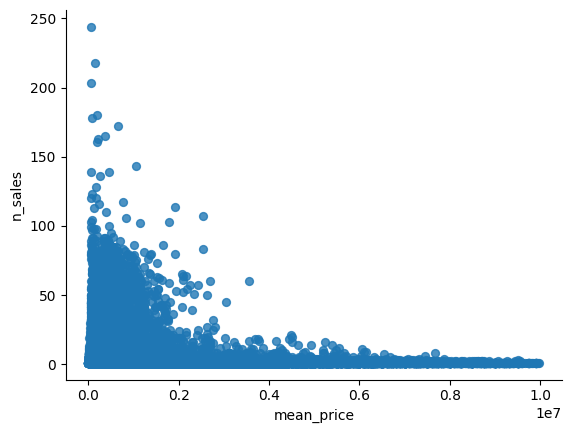

In [24]:
from matplotlib import pyplot as plt
filtered_avg.plot(kind='scatter', x='mean_price', y='n_sales', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

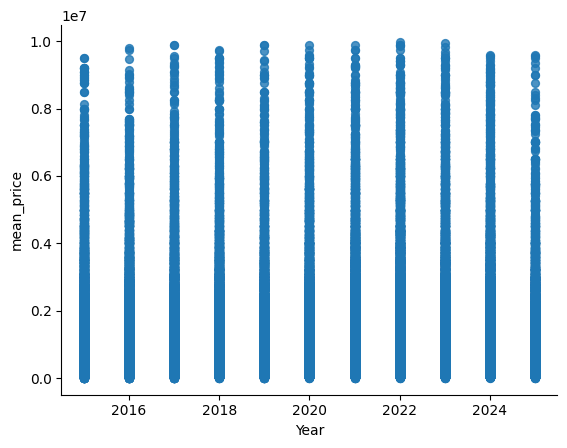

In [25]:
from matplotlib import pyplot as plt
filtered_avg.plot(kind='scatter', x='Year', y='mean_price', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

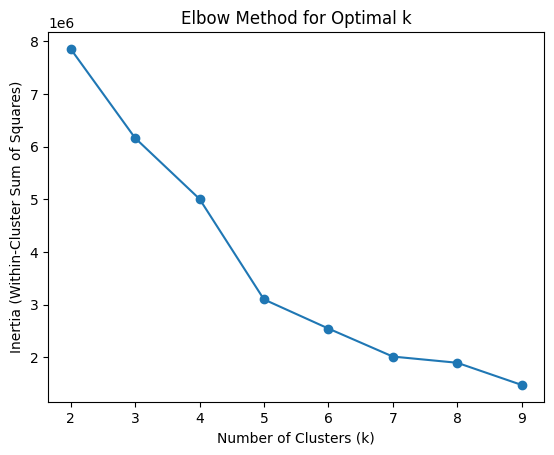

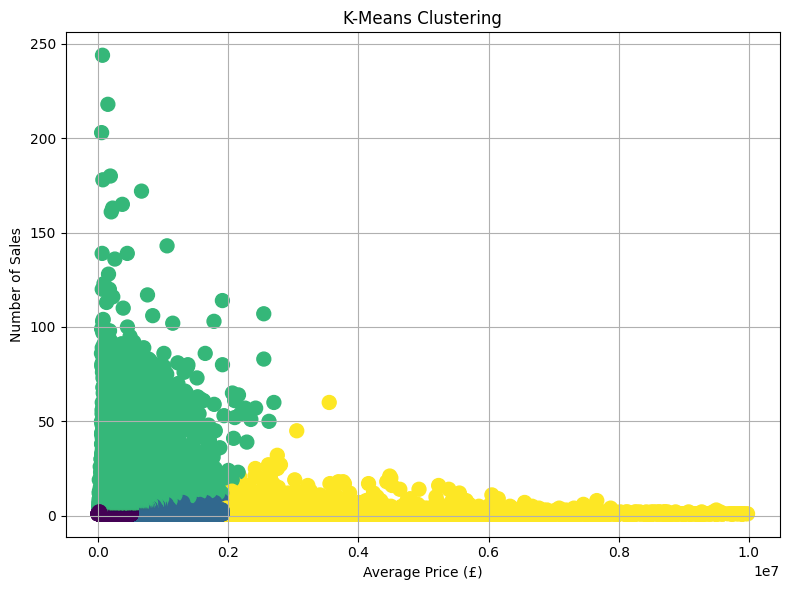

In [26]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

summary = filtered_avg.copy()

# Select features
features = summary[['mean_price', 'n_sales']].copy()

# Scale the data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

inertia = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=21)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

plt.plot(range(2, 10), inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Within-Cluster Sum of Squares)')
plt.title('Elbow Method for Optimal k')
plt.show()

# Run K-Means
kmeans = KMeans(n_clusters=4, random_state=21)
summary['Cluster'] = kmeans.fit_predict(scaled_features)

# Visualize
plt.figure(figsize=(8, 6))
plt.scatter(summary['mean_price'], summary['n_sales'],
            c=summary['Cluster'], cmap='viridis', s=100)
plt.xlabel('Average Price (£)')
plt.ylabel('Number of Sales')
plt.title('K-Means Clustering')
plt.grid(True)
plt.tight_layout()
plt.show()


###Cluster 0 (Black) — Low-Value, Low-Activity Markets

Low average price and very few sales.

Typically small, less-active markets - could be rural areas, low-demand regions, or markets with little turnover.

Represents the “quiet end” of the property spectrum.



---


###Cluster 1 (Blue) — Low-Price, High-Volume Areas

Low average prices but higher number of transactions.

Often commuter belts or entry-level markets where affordability drives volume (e.g., suburban zones, northern cities).

These are “affordable but active” segments.



---


###Cluster 2 (Green) - Mid-Range Stable Markets

Mid-price properties with moderate sales activity.

Likely suburban or semi-urban regions with steady demand.

Represents the middle class of the housing market — neither luxury nor low-value.


---



###Cluster 3 (Yellow) — High-Value, Low-Activity Markets

High average price, low transaction volume.

Classic high-end or exclusive postcodes (London zones, affluent rural areas).

Properties take longer to sell; turnover is limited, but values are high.

In [27]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans

# Encode Postcode_Area for internal use (not recommended for distance calc)
data = filtered_avg.copy()
data['Postcode_Code'] = LabelEncoder().fit_transform(data['Postcode'])

# Use Year, Price, n_sales
X = data[['Year', 'mean_price', 'n_sales']].copy()

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# KMeans
kmeans = KMeans(n_clusters=4, random_state=42)
data['Cluster'] = kmeans.fit_predict(X_scaled)


In [28]:
data

,Year,Town/City,Postcode,mean_price,median_price,std_price,n_sales,Postcode_Code,Cluster
0,2015,LONDON,SW14 7EW,"9,500,000","9,500,000",NaN,1,960896,3
1,2015,LONDON,SW3 6EY,"9,500,000","9,500,000",NaN,1,969052,3
2,2015,LONDON,SW1W 9JJ,"9,200,000","9,200,000",NaN,1,967042,3
3,2015,LONDON,SW1X 7AF,"9,200,000","9,200,000",NaN,1,967115,3
4,2015,LONDON,SW3 6BP,"9,200,000","9,200,000",NaN,1,969036,3
...,...,...,...,...,...,...,...,...,...
5131659,2025,BRADFORD,BD1 2HF,"13,500","13,500",NaN,1,56724,1
5131660,2025,BIRMINGHAM,B24 0PB,"12,500","12,500",NaN,1,10939,1
5131661,2025,LEEDS,LS1 2EX,"10,557","10,557",NaN,1,520802,1
5131662,2025,BISHOP AUCKLAND,DL14 6RA,"10,000","10,000",NaN,1,275416,1


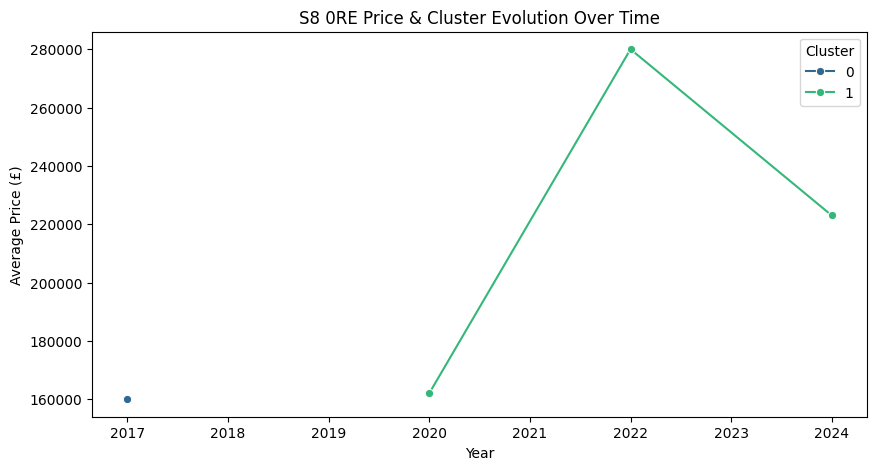

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

# Drop NaNs first to avoid errors
valid_postcodes = full_data["Postcode"].dropna().unique()

# Randomly pick one postcode
random_postcode = random.choice(valid_postcodes)

area_history = data[data['Postcode'] == random_postcode]


plt.figure(figsize=(10, 5))
sns.lineplot(x='Year', y='mean_price', hue='Cluster', data=area_history, palette='viridis', marker='o')
plt.title(f"{random_postcode} Price & Cluster Evolution Over Time")
plt.ylabel("Average Price (£)")
plt.show()


In [30]:
area_history

,Year,Town/City,Postcode,mean_price,median_price,std_price,n_sales,Postcode_Code,Cluster
1345873,2017,SHEFFIELD,S8 0RE,"160,000","160,000",NaN,1,836522,0
2783240,2020,SHEFFIELD,S8 0RE,"162,000","162,000",NaN,1,836522,1
3719382,2022,SHEFFIELD,S8 0RE,"280,000","280,000",0,2,836522,1
4688784,2024,SHEFFIELD,S8 0RE,"223,000","223,000",NaN,1,836522,1


#Most Desired Place to Live
Based on cumulative number of sales over time.

In [31]:
# Group by Postcode and sum all sales
most_desired = data.groupby('Postcode')['n_sales'].sum().reset_index()
most_desired = most_desired.sort_values(by='n_sales', ascending=False)

print("Top 10 most desired postcodes:\n", most_desired.head(10))


Top 10 most desired postcodes:
         Postcode  n_sales
536779   LU1 5FT      295
560587    M5 3WH      288
464775    L3 8HA      257
147791  CF10 3FH      252
959930  SW11 7AY      235
470547    L5 3AA      214
541341    M1 5GB      208
940716   SS2 6EB      206
314834   E14 9GU      204
782709  RG21 7AA      198


#Most Prestigious Place to Live
Based on average price over time (not just one expensive sale).

In [32]:
# Group by Postcode and take average price
prestigious = data.groupby('Postcode')['mean_price'].mean().reset_index()
prestigious = prestigious.sort_values(by='mean_price', ascending=False)

print("Top 10 most prestigious postcodes:\n", prestigious.head(10))


Top 10 most prestigious postcodes:
          Postcode  mean_price
971211    SW7 2TE   9,900,000
971260    SW7 3LZ   9,800,000
1063602    W9 1AA   9,750,000
374532   GU25 4NL   9,750,000
691699    NW8 9BQ   9,730,000
918248   SO24 9TW   9,600,998
966456   SW1P 3RX   9,500,000
691384    NW8 6AP   9,500,000
1056540   W11 2LE   9,500,000
960896   SW14 7EW   9,500,000


In [33]:
prestigious_search = full_data[full_data["Postcode"] == "SE1 9AN"]
prestigious_search

,Transaction unique identifier,Price,Date of Transfer,Postcode,Property Type,Old/New,Duration,PAON,Street,Town/City,District,County,PPD Category Type,Record Status,Year,Postcode_Area


#Areas With Highest Price Growth
Postcodes where price increased the most between first and last year (with at least 2 sales in each year).

In [40]:
first_price = (
    yearly_price
    .merge(first_last[['Postcode', 'first_year']],
           left_on=['Postcode', 'Year'],
           right_on=['Postcode', 'first_year'])
    [['Postcode', 'mean_price']]
    .rename(columns={'mean_price': 'mean_price_start'})
)

last_price = (
    yearly_price
    .merge(first_last[['Postcode', 'last_year']],
           left_on=['Postcode', 'Year'],
           right_on=['Postcode', 'last_year'])
    [['Postcode', 'mean_price']]
    .rename(columns={'mean_price': 'mean_price_end'})
)

growth = first_price.merge(last_price, on='Postcode')
growth['price_growth'] = growth['mean_price_end'] - growth['mean_price_start']

growth


,Postcode,mean_price_start,mean_price_end,price_growth
0,AL1 1AJ,"505,000","732,500","227,500"
1,AL1 1AR,"331,250","323,000","-8,250"
2,AL1 1AS,"705,000","608,750","-96,250"
3,AL1 1AT,"1,005,000","1,230,000","225,000"
4,AL1 1AU,"1,450,000","1,471,875","21,875"
...,...,...,...,...
701424,YO8 9XF,"196,250","278,000","81,750"
701425,YO8 9XG,"169,750","222,000","52,250"
701426,YO8 9XJ,"181,000","181,000",0
701427,YO8 9XN,"209,000","241,250","32,250"


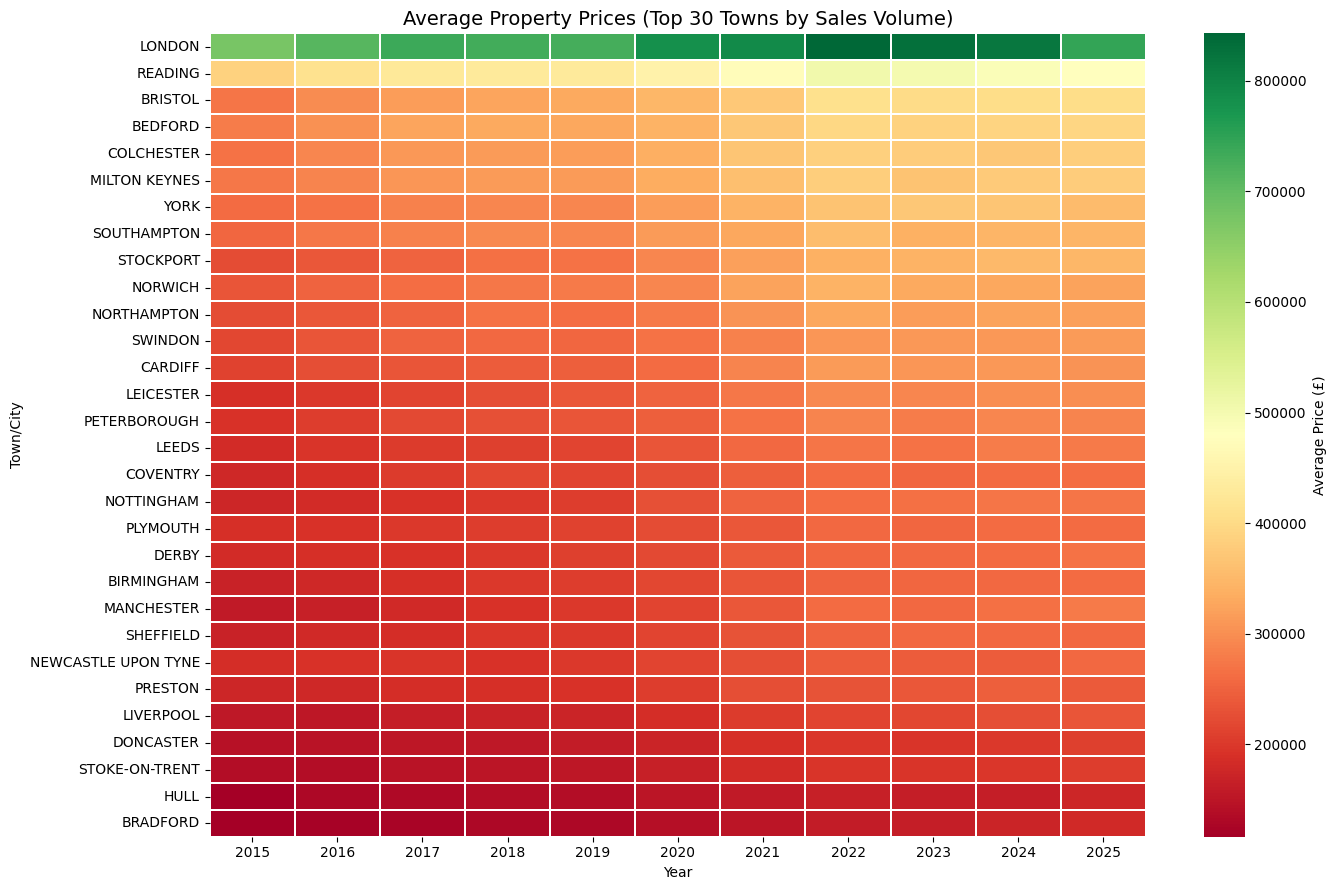

In [47]:
# --- Filter to top 30 towns by transaction volume ---
top_towns = (
    data.groupby('Town/City')['n_sales']
    .sum()
    .nlargest(30)
    .index
)

# Aggregate mean price per Town/City and Year
town_year = (
    data[data['Town/City'].isin(top_towns)]
    .groupby(['Town/City', 'Year'])['mean_price']
    .mean()
    .reset_index()
)

# Pivot for heatmap
pivot_town = town_year.pivot(index='Town/City', columns='Year', values='mean_price')

# Sort by most recent mean price
pivot_town = pivot_town.loc[
    pivot_town[sorted(pivot_town.columns)].mean(axis=1).sort_values(ascending=False).index
]

# --- Plot ---
plt.figure(figsize=(14, 9))
sns.heatmap(
    pivot_town,
    cmap='RdYlGn',
    linewidths=0.3,
    linecolor='white',
    cbar_kws={'label': 'Average Price (£)'}
)

plt.title('Average Property Prices (Top 30 Towns by Sales Volume)', fontsize=14)
plt.xlabel('Year')
plt.ylabel('Town/City')
plt.tight_layout()
plt.show()
